# Goal generation with Natural Language - Proof of Concept

Simple proof-of-concept of our approach with Stable Diffusion applied to the maze environment from procgen

## CUDA Utils

In [ ]:
import torch
import gc

In [ ]:
# set this to 'cpu' for CPU and 'cuda' for GPU
device = "cuda"

In [ ]:
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True

In [ ]:
def clear_cuda_memory():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()  # https://forums.fast.ai/t/clearing-gpu-memory-pytorch/14637
    gc.collect()

## Procgen

In [ ]:
from PIL import Image
from procgen import ProcgenGym3Env

In [ ]:
maze_env = ProcgenGym3Env(
    num=1,
    env_name="maze",
    start_level=33,
    num_levels=1,
)

In [ ]:
rew, obs, first = maze_env.observe()

Original dimensions W, H:  64 64
Scaling to 768x768


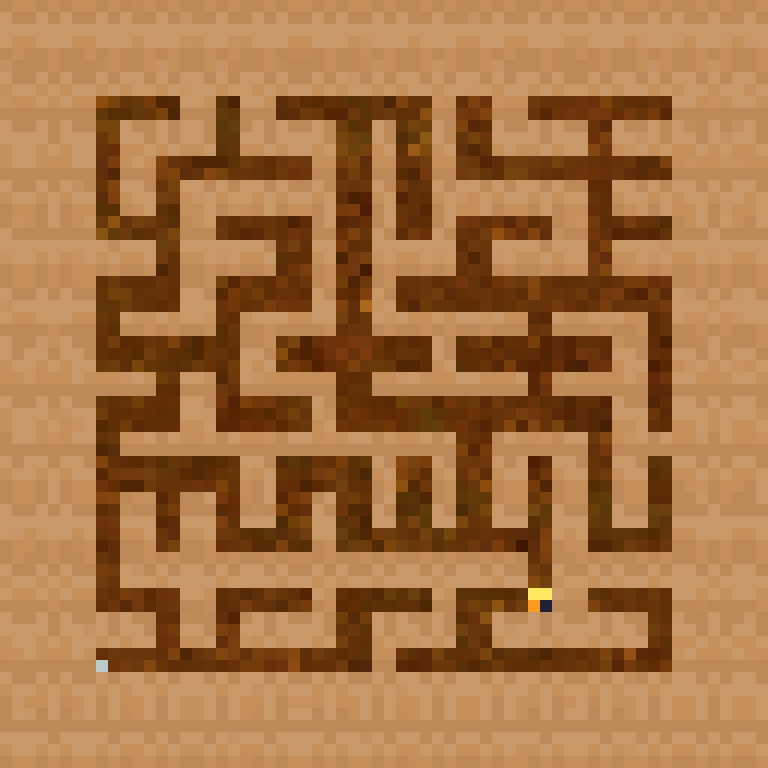

In [ ]:
start_state_arr = obs["rgb"].squeeze()

width = start_state_arr.shape[1]
height = start_state_arr.shape[0]
print("Original dimensions W, H: ", width, height)
display_scaling = 8
print(f"Scaling to 768x768")
start_state_image = Image.fromarray(start_state_arr)
start_state_image.resize((768, 768), Image.NEAREST)

In [ ]:
# make sure our conditioning image is at most 768 by 768 in size
start_state_image.thumbnail((786, 768), resample=Image.NEAREST)
large_start_state = start_state_image.resize((768, 768), Image.NEAREST)
large_start_state.thumbnail((768, 768), resample=Image.NEAREST)

## Diffusion

In [ ]:
import diffusers

Error caught was: No module named 'triton'


In [ ]:
diffusion_pipeline = diffusers.DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
diffusion_pipeline.to(device)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.14.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
# check if it works
output = diffusion_pipeline("An image of a squirrel in Picasso style")

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


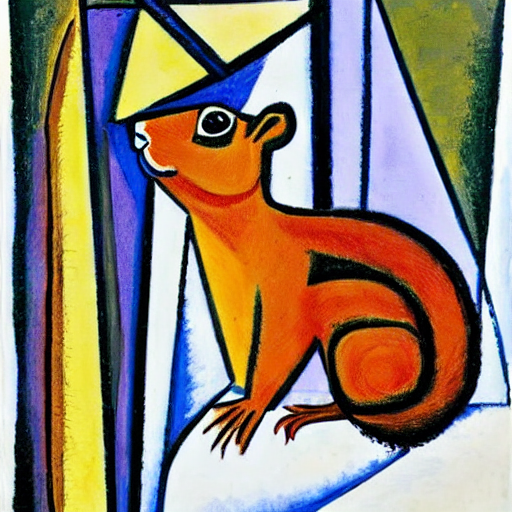

In [ ]:
output_image = output.images[0]
print(type(output_image))
output_image

Seems like it does work!

In [ ]:
# let's see if we can directly generate our goal state
output = diffusion_pipeline(
    "The OpenAI Procgen Maze RL environment, with the cheese succesfully collected"
)

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


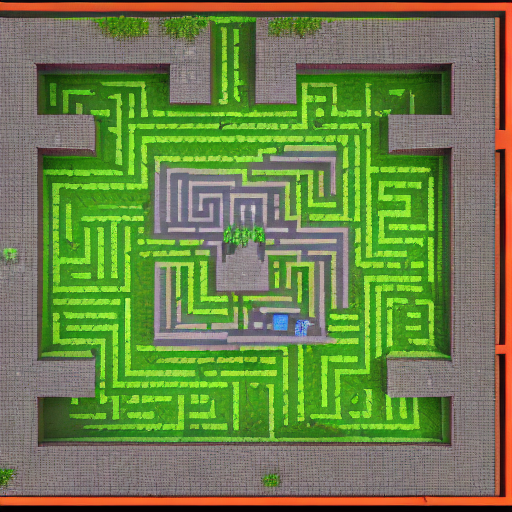

In [ ]:
output_image = output.images[0]
print(type(output_image))
output_image

In [ ]:
clear_cuda_memory()

Ok, conditioning on text alone is probably going to be very difficult to generate our goal state. As expected, we need to condition on the start state too, and use text for guidance.

## Generating Procgen Goal States with image-condition text-guided diffusion

### Naive Text-Guided Img2Img

In [ ]:
# our diffusion pipeline needs to change now:

img2img_tg = diffusers.StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None
)
# memory optimizations
img2img_tg.enable_model_cpu_offload()
img2img_tg.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
# the text guidance (note: i have tried several variations)
prompt = "The cheese has been removed from the environment"

In [ ]:
# note: i played around with the parameters a bit here
output = img2img_tg(
    prompt=prompt,
    image=large_start_state,
    strength=0.35,
    guidance_scale=10,
    num_inference_steps=100,
)

  0%|          | 0/35 [00:00<?, ?it/s]

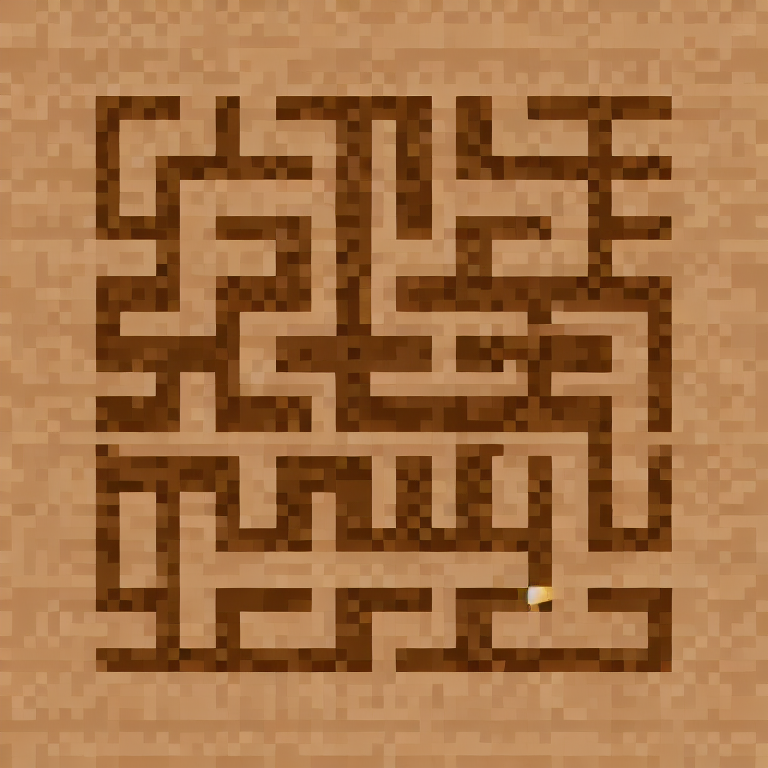

In [ ]:
output.images[0]

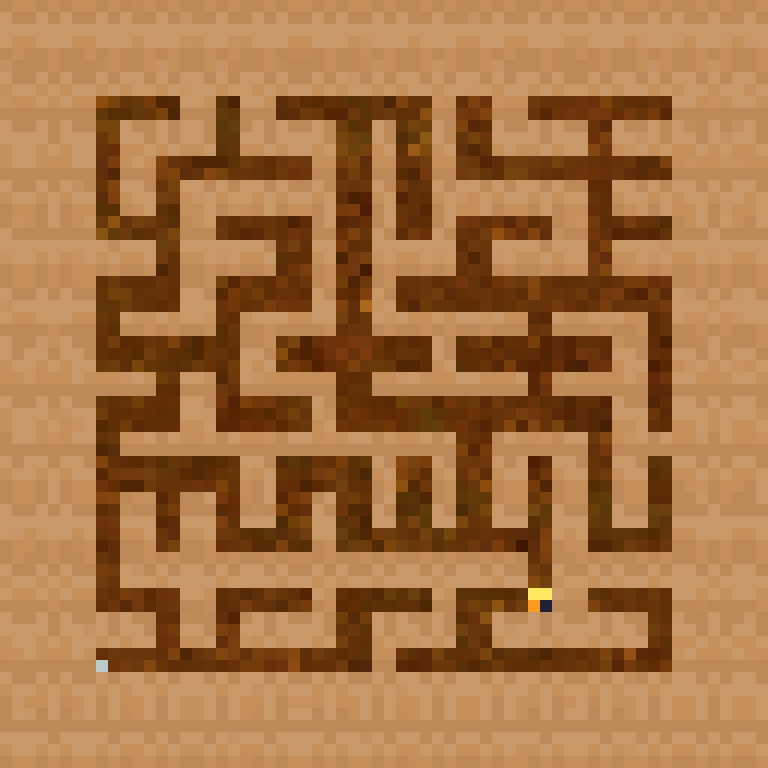

In [ ]:
large_start_state

This worked ok-ish, but in general requires a lot of messing with the prompt and the parameters and is very high variance -- I don't think it will scale well. Let's try using some techniques for more controlled generation.

In [ ]:
clear_cuda_memory()

Let's try with different pipelines. I don't think I will get very lucky with prompting alone, and it has too high variance.

### InstructPix2Pix

> Instruct Pix2Pix is fine-tuned from stable diffusion to support editing input images. It takes as inputs an image and a prompt describing an edit, and it outputs the edited image. Instruct Pix2Pix has been explicitly trained to work well with InstructGPT-like prompts.

Perhaps this instruction-following nature will allow us to control the output more succesfully.

In [ ]:
model_id = "timbrooks/instruct-pix2pix"
pipe = diffusers.StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id, safety_checker=None, torch_dtype=torch.float16
)
# memory optimizations
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

First, let's try it on an example picture to see if it works

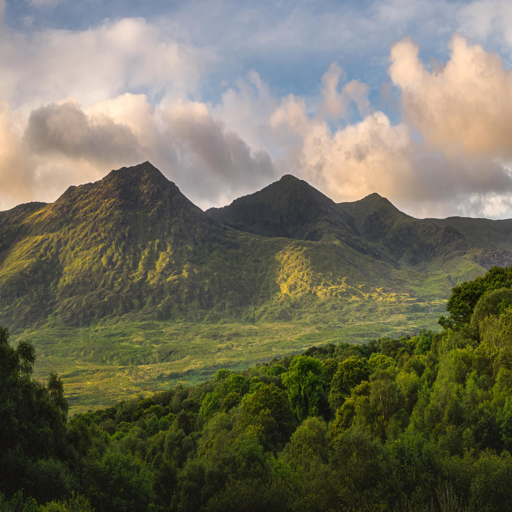

In [ ]:
import requests
from io import BytesIO


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


img_url = "https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/mountain.png"

image = download_image(img_url).resize((512, 512))

image

In [ ]:
prompt = "Add fireworks to the sky"
new_image = pipe(prompt=prompt, image=image).images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

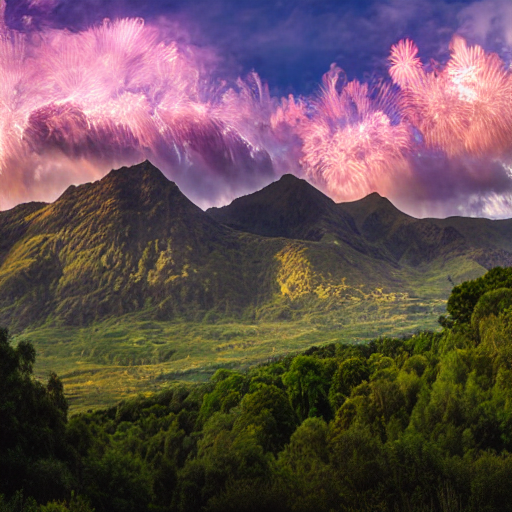

In [ ]:
new_image

Ok, now let's try with our problem. Note that we need to rephrase the prompt a bit because the model is fine-tuned to follow instructions.

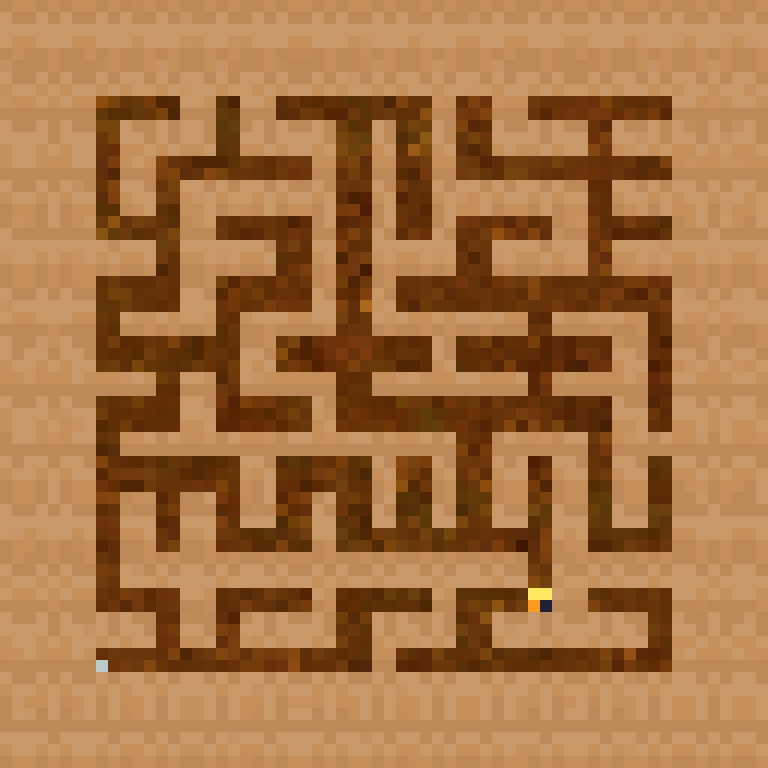

In [ ]:
# note, I have tried several prompts
prompt = "Cover the yellow square with the background"
large_start_state

In [ ]:
output = pipe(prompt, image=large_start_state)

  0%|          | 0/100 [00:00<?, ?it/s]

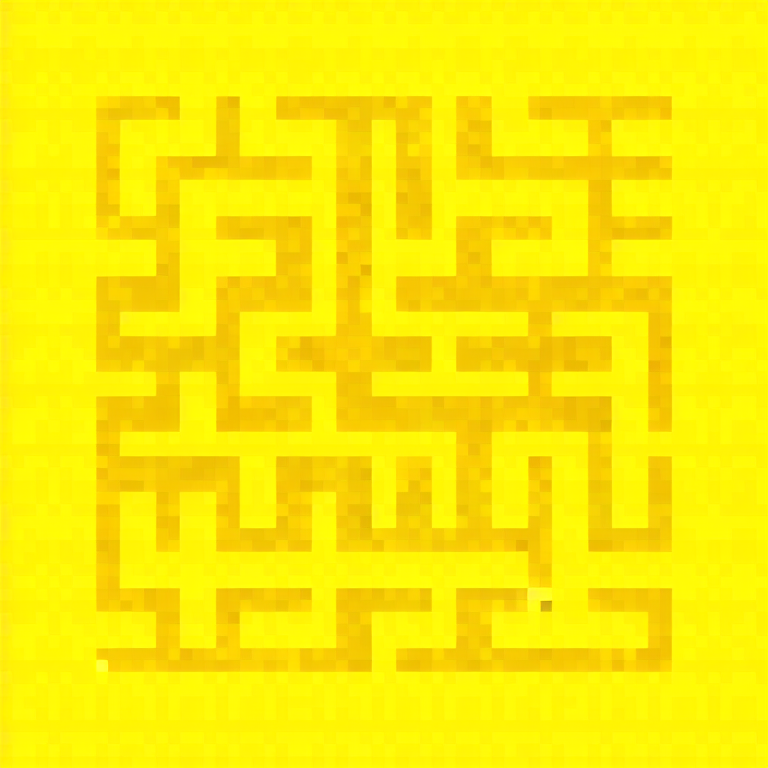

In [ ]:
output.images[0]

In [ ]:
clear_cuda_memory()

This is much worse than even the vanilla mode. From what I can tell this model is not very well suited for RL environments.

We may need to fine-tune SD on RL environments, either completely or more specifically with something like textual inversion.